In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [2]:

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")


TensorFlow version: 2.19.0
Keras version: 3.9.2


In [ ]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
gender_submission_df= pd.read_csv('gender_submission.csv')

In [4]:
# Separate target variable from features
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']


In [ ]:
# Identify categorical and numerical features
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']


In [6]:
# Create preprocessor
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # For Age and Fare
    ('scaler', StandardScaler())
])


In [7]:

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # For Embarked
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [8]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop other columns like 'Name', 'Ticket', 'Cabin'
)


In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Apply preprocessing to the training and validation sets
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)


In [ ]:
# Get the number of features after preprocessing
input_shape = X_train_processed.shape[1]
print(f"Number of features after preprocessing: {input_shape}")


Number of features after preprocessing: 12


In [ ]:
# Build the Feed-forward Neural Network Model ---

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3), # Added dropout for regularization
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])


C:\Users\OlesiaBrusentseva\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Model ---

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_processed, y_train,
                    epochs=100, # early stopping will control it
                    batch_size=32,
                    validation_data=(X_val_processed, y_val),
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5741 - loss: 0.6857 - val_accuracy: 0.6425 - val_loss: 0.6196
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6434 - loss: 0.6242 - val_accuracy: 0.7151 - val_loss: 0.5734
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7154 - loss: 0.5820 - val_accuracy: 0.7654 - val_loss: 0.5379
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7495 - loss: 0.5433 - val_accuracy: 0.7654 - val_loss: 0.5000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7896 - loss: 0.5256 - val_accuracy: 0.8156 - val_loss: 0.4691
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8006 - loss: 0.4739 - val_accuracy: 0.7989 - val_loss: 0.4481
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8273 - loss: 0.4336 - val_accuracy: 0.7989 - val_loss: 0.4371
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7832 - loss: 0.4674 - val_accuracy: 0.8045 - v

In [ ]:
# Evaluate the Model

loss, accuracy = model.evaluate(X_val_processed, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Loss: 0.4261
Validation Accuracy: 0.8156


In [ ]:
# Make predictions on the validation set
y_pred_proba = model.predict(X_val_processed)
y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.84      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179


Confusion Matrix:
[[95 10]
 [23 51]]


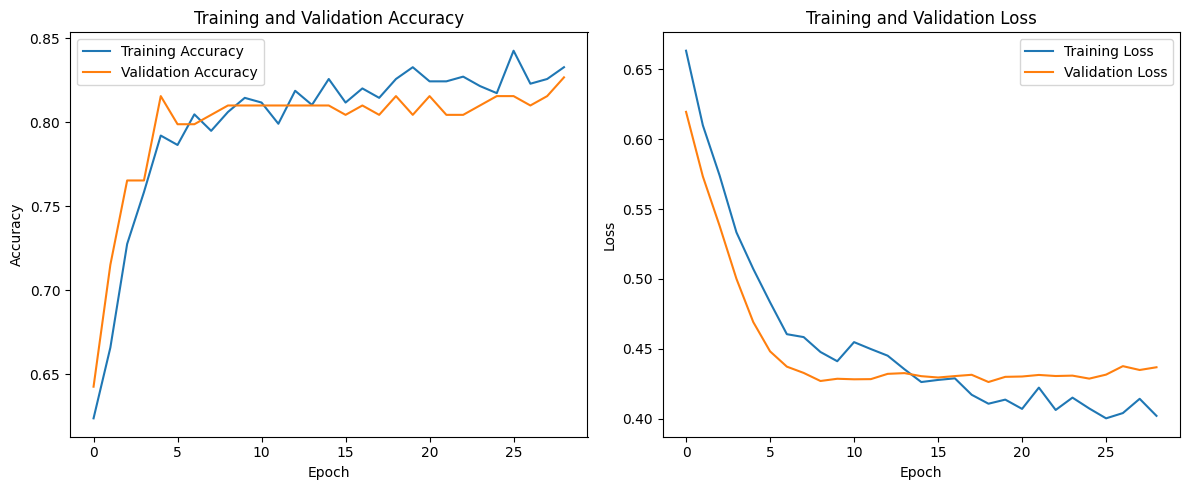

In [ ]:
# Plotting training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Preprocess Test Data
print("Preprocessing test data using the fitted preprocessor...")
# Store PassengerId before dropping it for preprocessing
passenger_ids = test_df['PassengerId']
X_test_processed = preprocessor.transform(test_df)


Preprocessing test data using the fitted preprocessor...


In [ ]:
# Make Predictions on Test Data ---
print("Making predictions on test data...")
y_test_pred_proba = model.predict(X_test_processed)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)


Making predictions on test data...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
# Evaluate against gender_submission.csv ---
print("\nEvaluating model performance on test data using gender_submission.csv...")
# The 'Survived' column in gender_submission.csv is our true labels for the test set
y_true_test = gender_submission_df['Survived']



Evaluating model performance on test data using gender_submission.csv...


In [ ]:
accuracy_test = accuracy_score(y_true_test, y_test_pred)
print(f"Test Accuracy (compared to gender_submission.csv): {accuracy_test:.4f}")

print("\nClassification Report on Test Data:")
print(classification_report(y_true_test, y_test_pred))

print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_true_test, y_test_pred))


Test Accuracy (compared to gender_submission.csv): 0.9019

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       266
           1       0.92      0.80      0.86       152

    accuracy                           0.90       418
   macro avg       0.91      0.88      0.89       418
weighted avg       0.90      0.90      0.90       418


Confusion Matrix on Test Data:
[[255  11]
 [ 30 122]]
